# Customer Query Classification
### Fatemeh Khosravi & Hoori Javadnia

### Classification Modeling

In [ ]:
#!pip install plotly
#!python -m nltk.downloader stopwords
#!pip install --upgrade scikit-learn
#!pip install transformers

In [64]:
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
%matplotlib inline
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
from nltk.tokenize import word_tokenize
import random
import re
re.compile('<title>(.*)</title>')
import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.naive_bayes import MultinomialNB

### Read the Data

In [65]:
# Read data

customer_queries = pd.read_csv('customer_query.csv')

### Clean the Data

In [66]:
# Some punctuation variations

punctuation = set(punctuation)


# Stopwords

sw = stopwords.words("english")


# Useful regex

whitespace_pattern = re.compile(r"\s+")


#Descriptive function

def descriptive_stats(tokens, num_tokens = 10, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    if verbose :
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")

        counts = Counter(tokens)

        if num_tokens > 0 :
            print("The top ten most common tokens are:")
            top_tokens=counts.most_common(num_tokens)
            top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
            print(top_token_df)

    return([len(tokens),
           len(set(tokens)),
           len("".join(tokens)),
           len(set(tokens))/len(tokens)])





# Remove stop words

def remove_stop(tokens) :
    return([t for t in tokens if t.lower() not in sw])

# Remove punctuation

def remove_punctuation(text, punct_set=punctuation) :
    return("".join([ch for ch in text if ch not in punct_set]))

# Remove white space

def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

# Tokenization

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    return([t for t in whitespace_pattern.split(text) if t])

# Join tokens

def join_tokens(tokens):

    text = " ".join(tokens)

    return(text)


# Pipeline function

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)


In [67]:
# Apply processing pipeline

prep_pipeline = [str.lower, remove_punctuation,remove_whitespace, tokenize, remove_stop, join_tokens]

# Tokenization on 'Query' column

customer_queries["tokens"] = customer_queries["Query"].apply(prepare, pipeline = prep_pipeline)

customer_queries.sample(10)


,Query,Class,tokens
6782,"\r\n\r\nMy WiFi is not connecting, what do I n...",Tech. Support,wifi connecting need order get online
9628,\r\n\r\nHow can I pay my bill quickly and secu...,Billing,pay bill quickly securely
17849,\r\n\r\nI recently purchased an item from your...,Returns,recently purchased item store quality also exp...
24020,\r\n\r\nCompany Striker asks: Is the card info...,Billing,company striker asks card information provided...
5223,\r\n\r\nWas there any bit of damage to the del...,Returns,bit damage delivered order partially refunding...
1262,\r\n\r\nDo I need to provide proof of purchase...,Returns,need provide proof purchase return
30009,\r\n\r\nI have a problem with email not loadin...,Tech. Support,problem email loading properly laptop open get...
21977,\r\n\r\nI bought a product from your store rec...,Returns,bought product store recently meeting expectat...
39189,\r\n\r\nWhy have I not received a replaced ite...,Returns,received replaced item order even though state...
29706,"\r\n\r\nI reinstalled my printer on my laptop,...",Tech. Support,reinstalled printer laptop computer wont recog...


###  Exploratory Naive Bayes

We'll first build a NB model on the query data itself, as a way to understand what words distinguish between the four classes. First, pull in the query for each class and prepare it for use in Naive Bayes.

We will use the DataFrame.itertuples() function to iterate over each of the row of the customer_queries Dataframe and construct a list out of the query and related class of each row.

In [68]:
query_data =[]

# Iterate over each row
for row in customer_queries.itertuples():
    Query=row.Query
    Class= row.Class
    clean_text=prepare(Query, pipeline=prep_pipeline)

    # append the list to the final list
    query_data.append([clean_text, Class])

random.choices(query_data,k=10)

[['payment options recent purchase', 'Billing'],
 ['information need order process return physical receipt bank record purchase count proof purchase',
  'Returns'],
 ['computer randomly deleting files im worried perhaps drive corrupt something blocking accessing fix',
  'Tech. Support'],
 ['product installed outdoors', 'Product Inquiry'],
 ['im considering buying large bidet weatherseasonal changes affect models large bidets reliable',
  'Product Inquiry'],
 ['much interference productcreate phone line im connected wirelessly',
  'Product Inquiry'],
 ['billing office didnt receive first installment invoiced earlier – find way process payments yet',
  'Billing'],
 ['new laptop wont turn despite fully charged', 'Tech. Support'],
 ['saw similar product website strikes costeffective difference product one circumstance one better',
  'Product Inquiry'],
 ['invoice total payments remedies case issue payment', 'Billing']]

### Make Function to Turn Tokens into Features

* We wanted to keep the number of features reasonable, so we only used words that occur at least word_cutoff times (in our case 5).  

As we can see the total number of features with word_cutoff = 0 is 20,993 and the total number of features with word_cutoff=5 is 3,950
  

In [69]:
# without cut off

word_cutoff = 0

tokens = [w for q, c in query_data for w in q.split()]

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)

print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")


With a word cutoff of 0, we have 20993 as features in the model.


In [70]:
# with cut off

word_cutoff = 5

tokens = [w for q, c in query_data for w in q.split()]

word_dist = nltk.FreqDist(tokens)

feature_words_cutoff = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words_cutoff.add(word)

print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words_cutoff)} as features in the model.")

With a word cutoff of 5, we have 3950 as features in the model.


In [71]:
def query_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.

       Args:
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word
            in `text` must be in fw in order to be returned. This
            prevents us from considering very rarely occurring words.

       Returns:
            A dictionary with the words in `text` that appear in `fw`.
            Words are only counted once.
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of
            {'quick' : True,
             'fox' :    True}

    """


    ret_dict = dict()

    for word in text.split():
        if word in fw:
            ret_dict [word]=True
    return(ret_dict)

###  Build our Feature Set

In [72]:
featuresets = [(query_features(q,feature_words_cutoff),c) for (q, c) in query_data]

In [73]:
random.seed(123)
random.shuffle(featuresets)
test_size = 2000
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.94


### Feature Importance

Out of the top 25 words, 8 words are repeated more often in 'Return', 9 words are repeated more often in 'Billing' and 8 top words among 25 words are related to 'Tech Support’.
* It seems that the 'Return' class put a lot of emphasis on words like refund which is reasonable while people will ask refund for their returning items.

* In ‘Billing’ class we can see top words are billing, statement, total, payment etc.

* For ‘Tech. Support’ class words like connect, connection, computer and networks show most of queries are related to the hardware and or software aplications.

* Among top 25 words there are no words related to the ‘Product Inquiry’ class.  

In [74]:
classifier.show_most_informative_features(25)

Most Informative Features
                  refund = True           Return : Tech.  =   1202.6 : 1.0
                  return = True           Return : Tech.  =    778.1 : 1.0
                    turn = True           Tech.  : Billin =    645.5 : 1.0
                  laptop = True           Tech.  : Billin =    628.7 : 1.0
                    bill = True           Billin : Tech.  =    627.2 : 1.0
                 billing = True           Billin : Return =    585.3 : 1.0
               returning = True           Return : Tech.  =    507.3 : 1.0
                 balance = True           Billin : Return =    503.5 : 1.0
                  policy = True           Return : Tech.  =    415.8 : 1.0
                   total = True           Billin : Tech.  =    375.9 : 1.0
              connection = True           Tech.  : Return =    348.5 : 1.0
                 connect = True           Tech.  : Return =    347.3 : 1.0
                 payment = True           Billin : Tech.  =    314.6 : 1.0

Let's take a random sample and see how our classifer does.

In [83]:
query_data_sample = random.choices(query_data,k=10)

for Query, Class in query_data_sample :
    estimated_class = classifier.classify(query_features(Query,feature_words_cutoff))


    print(f"Here's our (cleaned) query: {Query}")
    print(f"Actual class is {Class} and our classifer says { estimated_class}.")
    print("")


Here's our (cleaned) query: gmail account examplegmailcom longer appears login desktop screen
Actual class is Tech. Support and our classifer says Tech. Support.

Here's our (cleaned) query: product enlarged fit ipad pro
Actual class is Product Inquiry and our classifer says Product Inquiry.

Here's our (cleaned) query: customer reviews product verified many customers happy purchases
Actual class is Product Inquiry and our classifer says Returns.

Here's our (cleaned) query: recently purchased toaster store noticed wasnt heating food making error4t wanted see could resolve issue
Actual class is Product Inquiry and our classifer says Product Inquiry.

Here's our (cleaned) query: payment method use pay balance 425 due date april 13th
Actual class is Billing and our classifer says Billing.

Here's our (cleaned) query: balance due last statement account number 1254mpjnh
Actual class is Billing and our classifer says Billing.

Here's our (cleaned) query: oven wont heat set temperature somet

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [84]:
featuresets = [(query_features(q,feature_words_cutoff), c) for (q, c) in query_data]
accuracy=nltk.classify.accuracy(classifier, featuresets)
print(round(accuracy,2))

0.95


### Train Test Split

In [85]:
data= customer_queries[['tokens','Class']]

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(data['tokens'],data['Class'],test_size=0.2,
                                                    random_state=42, stratify=data['Class'])


print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])


Size of Training Data  32213
Size of Test Data  8054


### Term-Frequency Inverse Document Frequency (TF- IDF) vectorization

In [86]:
tfidf = TfidfVectorizer(min_df = 5, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

### Naive Bayes Classifier

In [87]:
# Fit the model

nb_clf= MultinomialNB()
nb_clf.fit(X_train_tf, Y_train)

# Model evaluation

Y_pred_nb = nb_clf.predict(X_test_tf)
print ('Accuracy Score - ',round( accuracy_score(Y_test, Y_pred_nb),2))



Accuracy Score -  0.95


### Confusion Matrix

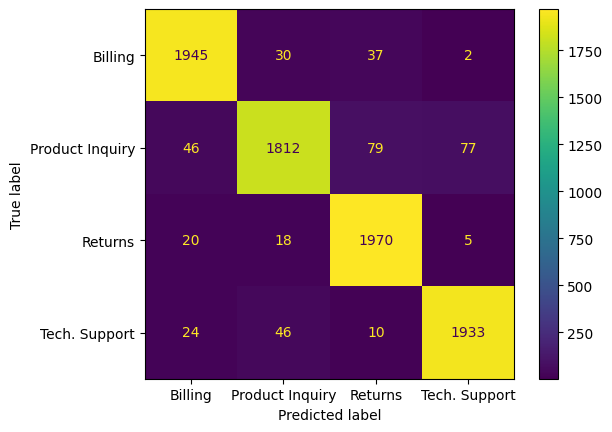

In [88]:
cm_nb=confusion_matrix(Y_test, Y_pred_nb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb,
                              display_labels=nb_clf.classes_)
disp.plot()

### Classification Report

In [89]:
print(classification_report(Y_test, Y_pred_nb))

                 precision    recall  f1-score   support

        Billing       0.96      0.97      0.96      2014
Product Inquiry       0.95      0.90      0.92      2014
        Returns       0.94      0.98      0.96      2013
  Tech. Support       0.96      0.96      0.96      2013

       accuracy                           0.95      8054
      macro avg       0.95      0.95      0.95      8054
   weighted avg       0.95      0.95      0.95      8054



### SVM Classification

In [90]:
# Fit the model

svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train_tf, Y_train)

# Model evaluation

Y_pred_svm = svm_clf.predict(X_test_tf)
print ('Accuracy Score - ',round( accuracy_score(Y_test, Y_pred_svm),2))

Accuracy Score -  0.96


### Confusion Matrix

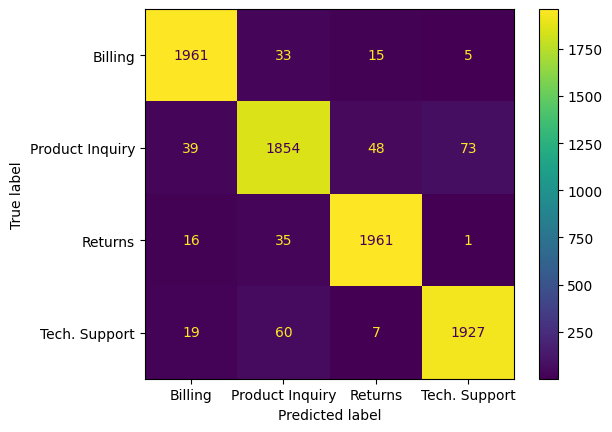

In [91]:
cm_svm=confusion_matrix(Y_test, Y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                              display_labels=svm_clf.classes_)
disp.plot()

### Classification Report

In [92]:
print(classification_report(Y_test, Y_pred_svm))

                 precision    recall  f1-score   support

        Billing       0.96      0.97      0.97      2014
Product Inquiry       0.94      0.92      0.93      2014
        Returns       0.97      0.97      0.97      2013
  Tech. Support       0.96      0.96      0.96      2013

       accuracy                           0.96      8054
      macro avg       0.96      0.96      0.96      8054
   weighted avg       0.96      0.96      0.96      8054



In [133]:
# Actual and Predicted values

frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred_svm }
result = pd.DataFrame(frame)
result.sample(10)

,text,actual,predicted
8740,dispute remaining amount due recent bill,Billing,Billing
25651,use product,Product Inquiry,Product Inquiry
18349,recently returned product havent received refu...,Returns,Returns
30936,connect wifi network office,Tech. Support,Tech. Support
28435,get refund purchase,Returns,Returns
3449,whats shelf life product,Product Inquiry,Product Inquiry
29505,antivirus software expired renew without losin...,Tech. Support,Tech. Support
11293,return policy product full refund choose keep,Returns,Product Inquiry
6101,need send item back address pay return shippin...,Returns,Returns
5121,please get refund item purchased online receiv...,Returns,Returns


### Cross-Validation

In order to have the right balance between underfitting, overfitting and have more realistic performance the 5-fold cross-validation technique was applied.

With this technique we use all observations and we do not create a separate holdout data for testing the model. So, if our model suffers from the lack of data, cross validation can help to improve the learning phase.


In [134]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(X_train).toarray()

# Cross Validation with 5 folds
scores = cross_val_score(estimator=svm_clf,
                             X=df_tf,
                             y=Y_train,
                             cv=5)
print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())


Validation scores from each iteration of the cross validation  [0.9525066  0.95126494 0.95204097 0.95032599 0.95017075]
Mean value across of validation scores  0.9512618499686525
Standard deviation of validation scores  0.0009189961605249391


### SVC Classification With Grid Search

To tuning hyperparameters of the model for obtain the better results, SVC with grid search technique was applied. The best hyperparameters based on the predefined set are:

* 'model__loss': 'hinge'
* 'model__max_iter': 10000
* 'model__penalty': 'l2'
* 'tfidf__min_df': 5
* 'tfidf__ngram_range': (1, 3)

Best result identified by grid search  0.95

In [135]:
# Define a pipeline

training_pipeline = Pipeline(
        steps=[('tfidf', TfidfVectorizer(stop_words="english")),
                ('model', LinearSVC(random_state=42, tol=1e-5))])

#Define sets of parameters

grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__penalty': ['l2'],
        'model__loss': ['hinge'],
        'model__max_iter': [10000]
},{
'tfidf__min_df': [5, 10], 'tfidf__ngram_range': [(1, 3), (1, 6)], 'model__C': [1, 10],
'model__tol': [1e-2, 1e-3]
}]


grid_svc_clf = GridSearchCV(estimator=training_pipeline,
                                       param_grid=grid_param,
                                       cv=5)
# Fit the model

grid_svc_clf.fit(X_train, Y_train)

Y_pred_svc = grid_svc_clf.predict(X_test)


#Best parameters

best_params = grid_svc_clf.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = grid_svc_clf.best_score_
print("Best result identified by grid search ", best_result)

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.953900555503006


### Confusion Matrix

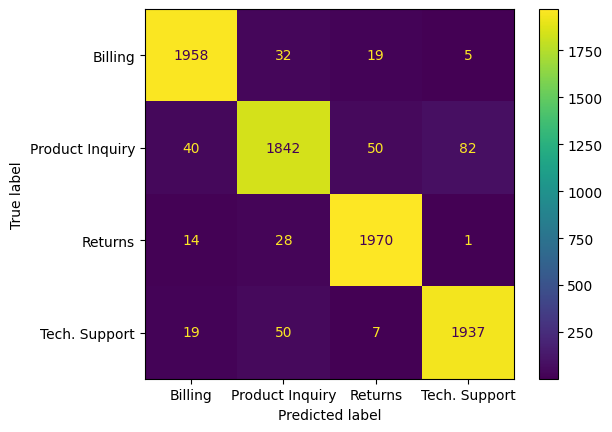

In [136]:
cm_svc=confusion_matrix(Y_test, Y_pred_svc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                              display_labels=grid_svc_clf.classes_)
disp.plot()

### Classification Report

In [137]:
print(classification_report(Y_test, Y_pred_svc))

                 precision    recall  f1-score   support

        Billing       0.96      0.97      0.97      2014
Product Inquiry       0.94      0.91      0.93      2014
        Returns       0.96      0.98      0.97      2013
  Tech. Support       0.96      0.96      0.96      2013

       accuracy                           0.96      8054
      macro avg       0.96      0.96      0.96      8054
   weighted avg       0.96      0.96      0.96      8054



In [138]:
gridsearch_results = pd.DataFrame(grid_svc_clf.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                        'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
0,1,0.953901,"{'model__loss': 'hinge', 'model__max_iter': 10..."
1,2,0.953776,"{'model__loss': 'hinge', 'model__max_iter': 10..."
5,3,0.952969,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."
9,3,0.952969,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."
4,5,0.952969,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."


We applied 3 different classification methods: Naive Bayes, SVM, and SVC. All models performed well to distinguish between 4 different classes with 95% to 96% overall accuracy. Highest accuracy is related to SVM classifier with accuracy of 96% and F1 score of 96%. Taking into account the running time of the model and the simplicity of the Naïve Bayes model without any hyperparameters, it may be cost effective to ignore a one percent difference in the accuracy of the model’s performance.